In [ ]:
! git clone https://github.com/westedcrean/master-thesis && pip install wandb loguru

In [ ]:
! cp -r master-thesis/* .

In [ ]:
! cd src && ./download_dataset.sh && python create_datasets.py

In [1]:
from pathlib import Path

import wandb
from wandb.keras import WandbCallback

import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sys

sys.path.append(str((Path.cwd().absolute() / "../src").resolve()))

2022-11-16 16:23:09.518007: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-16 16:23:09.522443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 16:23:09.522467: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from training.engine import train, test
from training.create_models import get_models_for_experiment
from datasets import numbers, get_class_name, log_dataset_statistics

2022-11-16 16:23:19.360345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-16 16:23:19.360405: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-16 16:23:19.360417: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ITEM-S127495): /proc/driver/nvidia/version does not exist
2022-11-16 16:23:19.360709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
train_data = numbers(subset="training")
validation_data = numbers(subset="validation")
test_data = numbers(path="../data/numbers/test", subset=None, validation_split=None)

class_labels = [get_class_name(cn) for cn in validation_data.class_names]

model = None

num_classes=10
input_shape=(32, 32, 3)

Found 61008 files belonging to 10 classes.
Using 48807 files for training.
Found 61008 files belonging to 10 classes.
Using 12201 files for validation.
Found 11699 files belonging to 10 classes.


In [ ]:
from typing import List, Tuple
import tensorflow as tf


def get_vgg_model(
    input_shape: tuple,
    num_classes: int,
    learning_rate: float,
    model_name: str,
    optimizer: tf.keras.optimizers.Optimizer = tf.keras.optimizers.Adam,
    loss: tf.keras.losses.Loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics: list = [tf.keras.metrics.CategoricalAccuracy()],
) -> Tuple[tf.keras.Model, dict]:
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    
    # Convolutional layers

    # flatten
    x = tf.keras.layers.Flatten()(x)

    # Dense layers
    x = tf.keras.layers.Dense(12, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    
    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    # Compile model
    model.compile(
        optimizer=optimizer(learning_rate=learning_rate),
        loss=loss,
        metrics=metrics,
    )

    config = dict(
        learning_rate=learning_rate,
        model_name=model_name,
    )

    return model, config

model, _ = get_vgg_model(
    input_shape=input_shape,
    num_classes=num_classes,
    learning_rate=0.001,
    model_name=f"VGG1",
)

In [4]:
history = train(
            train_data,
            model,
            epochs=2,
            validation_dataset=validation_data,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss", patience=6, restore_best_weights=True
                ),
            ],
        )
accuracy, y_true, y_pred, y_probas = test(test_data, model)        

Epoch 1/2
1387/1387 [==============================] - 24s 17ms/step - loss: 1.4766 - categorical_accuracy: 0.7632 - val_loss: 0.1258 - val_categorical_accuracy: 0.9672
Epoch 2/2
193/193 [==============================] - 1s 5ms/step - loss: 0.1018 - categorical_accuracy: 0.9718


2022-11-05 13:19:48.181 | INFO     | training.engine:test:26 - Accuracy: 0.9718, loss: 0.1018


1/1 [==============================] - 0s 22ms/step


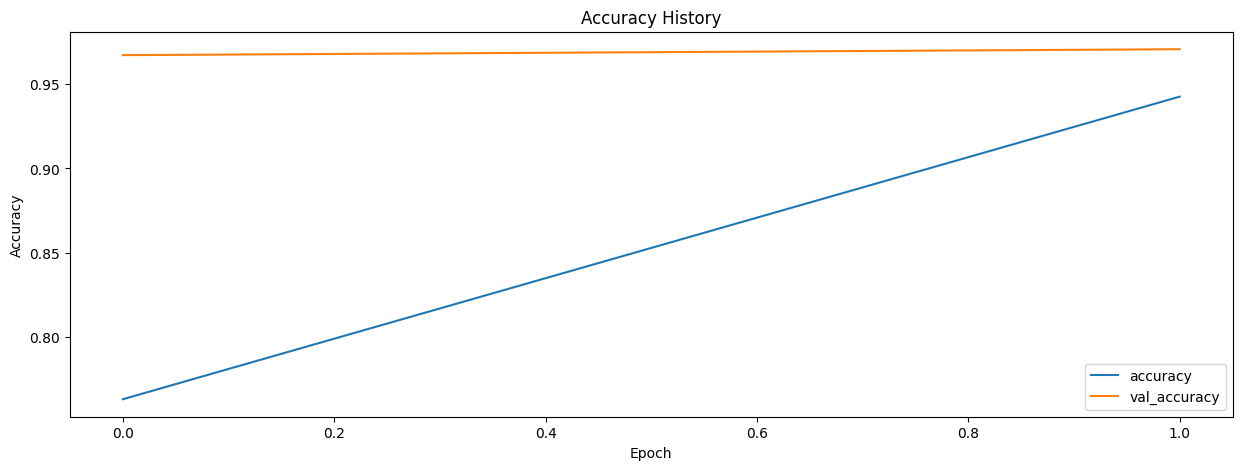

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# plot categorical_accuracy history in matplotlib
ax.plot(history.history["categorical_accuracy"], label="accuracy")
ax.plot(history.history["val_categorical_accuracy"], label="val_accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc="lower right")
ax.set_title("Accuracy History")
plt.show()

In [13]:
from sklearn.metrics import classification_report
import wandb


def get_classification_report(y_true, y_pred, class_labels, epoch=None):
    report = classification_report(
        y_true, y_pred, target_names=class_labels, output_dict=True
    )
    columns = ["epoch"] if epoch else []
    columns.extend(["precision", "recall", "f1-score", "support"])
    
    data = []
    for cl in class_labels:
        row = [epoch] if epoch else []
        row.extend([report[cl][k] for k in columns[1:]])
        data.append(row) 

    return wandb.Table(
        data=data,
        columns=["epoch", "class", "precision", "recall", "f1-score", "support"],
    )


get_classification_report(y_true, y_pred, class_labels=class_labels)

In [11]:
import pandas as pd
data = []


df = pd.DataFrame(data, columns=["class", "precision", "recall", "f1-score", "support"])

df

,class,precision,recall,f1-score,support
0,0,0.993528,0.995138,0.994332,617
1,1,0.995074,0.980583,0.987775,618
2,2,0.988275,0.953150,0.970395,619
3,3,0.996473,0.917208,0.955199,616
4,4,0.985197,0.969256,0.977162,618
5,5,0.980551,0.982143,0.981346,616
6,6,0.983819,0.988618,0.986212,615
7,7,0.985342,0.982143,0.983740,616
8,8,0.934375,0.969206,0.951472,617
9,9,0.888399,0.980551,0.932203,617
